# Mean nucleus value analysis

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import re
import matplotlib.pyplot as plt

In [2]:
def base_name_from_csv(filename: str) -> str:
    # remove extension
    name = re.sub(r"\.csv$", "", filename)
    # remove trailing _0262-0212 (or similar) if present
    name = re.sub(r"_\d+-\d+$", "", name)
    return name

In [3]:
path1 = "./Data_processing/020226_U2OS2_fixed_MGS1" # path to the folder containing the csv files with nucleus area and MFI
path2 = "./Data_processing/020226_U2OS2_fixed_MGS1/res8" # path to the folder with csv files containing the number of foci and their MFI

In [4]:
# ---- NUCLEI TABLE (path1) ----
dir_path1 = Path(path1)
files1 = sorted(dir_path1.glob("*.csv"))
dfs1 = []
for f in files1:
    key = base_name_from_csv(f.name)
    key = key[:-4]
    df = pd.read_csv(f)
    df["File_name"] = key
    dfs1.append(df)

final = pd.concat(dfs1, ignore_index=True)
final = final.rename(columns={"Area": "Nucleus_area", "Mean": "Nucleus_MFI"})
final = final[["File_name", "Nucleus_area", "Nucleus_MFI"]]

# ---- FOCI SUMMARY (path2) ----
dir_path2 = Path(path2)
files2 = sorted(dir_path2.glob("*.csv"))
foci_rows = []
for f in files2:
    key = base_name_from_csv(f.name)
    df = pd.read_csv(f)
    # count rows + mean intensity
    foci_rows.append({
        "File_name": key,
        "Foci_number": int(df.shape[0]),
        "Foci_MFI": float(df["intensity [photon]"].mean()) if "intensity [photon]" in df.columns else pd.NA
    })

foci_summary = pd.DataFrame(foci_rows)

# ---- MERGE ----
final = final.merge(foci_summary, on="File_name", how="left")
final["Foci_MFI"] = pd.to_numeric(final["Foci_MFI"], errors="coerce")

# Export file
final.to_csv(path2 + "/final.csv", index=False)

# Boxplots

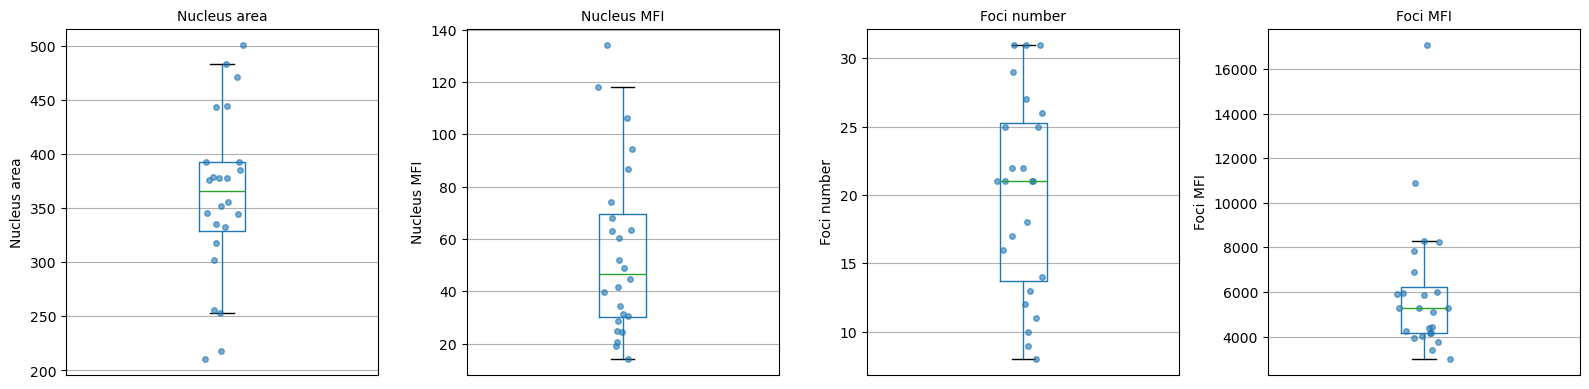

In [5]:
numeric_cols = final.select_dtypes(include="number").columns
n = len(numeric_cols)

fig, axes = plt.subplots(
    nrows=1,
    ncols=n,
    figsize=(4 * n, 4),   # controls size (smaller plots)
    sharey=False
)

# If only one column, axes is not a list
if n == 1:
    axes = [axes]

for ax, column_name in zip(axes, numeric_cols):
    # Boxplot
    final.boxplot(
        column=column_name,
        showfliers=False,
        ax=ax
    )

    # Jittered dots
    y = final[column_name].dropna().values
    x = np.random.normal(loc=1, scale=0.04, size=len(y))
    ax.plot(x, y, "o", alpha=0.6, markersize=4)

    # Labels
    ax.set_ylabel(column_name.replace("_", " "))
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_title(column_name.replace("_", " "), fontsize=10)

plt.tight_layout()
plt.show()


# Spearman correlation coefficient

In [7]:
cols = final.select_dtypes(include="number").columns

corr = pd.DataFrame(index=cols, columns=cols, dtype=float)
pvals = pd.DataFrame(index=cols, columns=cols, dtype=float)

for c1 in cols:
    for c2 in cols:
        x = final[c1]
        y = final[c2]
        mask = x.notna() & y.notna()
        if mask.sum() > 2:
            corr.loc[c1, c2], pvals.loc[c1, c2] = spearmanr(x[mask], y[mask])

print(corr)
print(pvals)

              Nucleus_area  Nucleus_MFI  Foci_number  Foci_MFI
Nucleus_area      1.000000    -0.086957    -0.286215  0.563478
Nucleus_MFI      -0.086957     1.000000     0.198518 -0.286957
Foci_number      -0.286215     0.198518     1.000000 -0.529672
Foci_MFI          0.563478    -0.286957    -0.529672  1.000000
               Nucleus_area    Nucleus_MFI    Foci_number       Foci_MFI
Nucleus_area  1.088022e-173   6.861953e-01   1.751393e-01   4.139999e-03
Nucleus_MFI    6.861953e-01  1.088022e-173   3.524132e-01   1.739742e-01
Foci_number    1.751393e-01   3.524132e-01  1.088022e-173   7.769948e-03
Foci_MFI       4.139999e-03   1.739742e-01   7.769948e-03  1.088022e-173


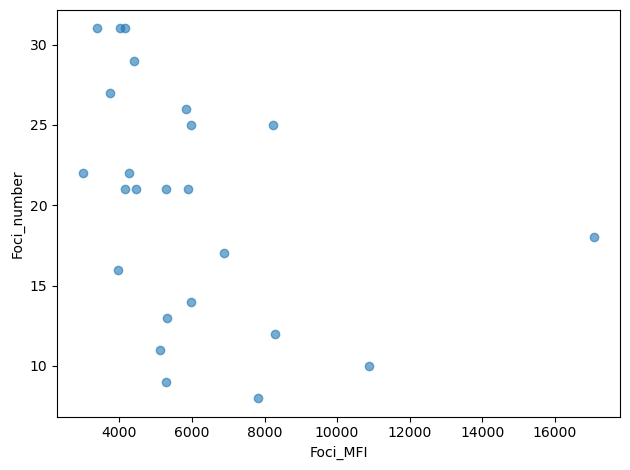

In [12]:
col1 = "Foci_MFI"
col2 = "Foci_number"

plt.figure()
plt.scatter(final[col1], final[col2], alpha=0.6)
plt.xlabel(col1)
plt.ylabel(col2)
plt.tight_layout()
plt.show()